# GAM

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
from preprocess import data
x_tl = data["x_timed_lagged"].reset_index(drop=True).shift(1)
x_germany = data["x_germany"].reset_index(drop=True)
x_austria = data["x_austria"].reset_index(drop=True)
y_germany = data["y_germany"].reset_index(drop=True)
y_austria = data["y_austria"].reset_index(drop=True)

In [85]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s

X_ger = pd.concat([x_germany, x_tl], axis=1).dropna().drop(columns=["DATE_FROM"]).reset_index(drop=True) #drop the first row of the df due to .shift(1)
X_aust = pd.concat([x_austria, x_tl], axis=1).dropna().drop(columns=["DATE_FROM"]).reset_index(drop=True)

y_ger = y_germany.iloc[1:].reset_index(drop=True)
y_aus = y_austria.iloc[1:].reset_index(drop=True)

In [20]:
for k, x in enumerate(X_ger.columns.tolist()):
    print(k, x)

0 GERMANY_BLOCK_DEMAND_[MW]
1 GERMANY_BLOCK_EXPORT_LIMIT_[MW]
2 GERMANY_BLOCK_CORE_PORTION_[MW]
3 TOTAL_MIN_CAPACITY_PRICE_[(EUR/MW)/h]
4 TOTAL_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]
5 TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]
6 GERMANY_MIN_CAPACITY_PRICE_[(EUR/MW)/h]
7 GERMANY_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]
8 GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]
9 GERMANY_IMPORT(-)_EXPORT(+)_[MW]
10 AUSTRIA_MIN_CAPACITY_PRICE_[(EUR/MW)/h]
11 AUSTRIA_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]
12 AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]
13 AUSTRIA_IMPORT(-)_EXPORT(+)_[MW]
14 GERMANY_SUM_OF_OFFERED_CAPACITY_[MW]


## GAM classiques

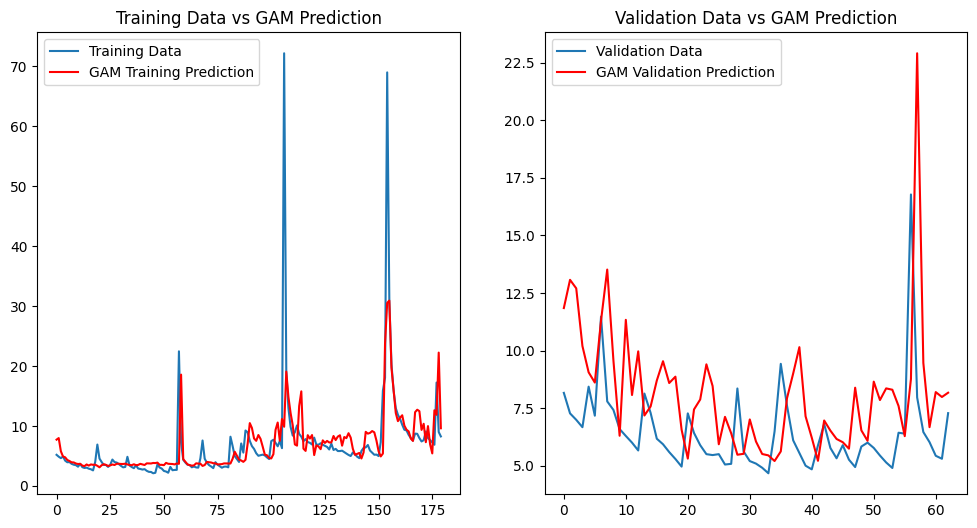

In [21]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train = X_ger[:180]
y_train = y_ger[:180]

X_valid = X_ger[180:]
y_valid = y_ger[180:]

# Define the model with a smoothing term for the first feature
gam = LinearGAM(s(6) + s(7) + s(8))

# Fit the model on the training set
gam.fit(X_train, y_train)

# Predict using the model on both training and validation sets
y_train_pred = gam.predict(X_train)
y_valid_pred = gam.predict(X_valid)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data and predictions
plt.subplot(1, 2, 1)
plt.plot(y_train, label='Training Data')
plt.plot(y_train_pred, color='red', label='GAM Training Prediction')
plt.title('Training Data vs GAM Prediction')
plt.legend()

# Plot validation data and predictions
plt.subplot(1, 2, 2)
plt.plot(y_valid.reset_index(drop=True), label='Validation Data')
plt.plot(y_valid_pred, color='red', label='GAM Validation Prediction')
plt.title('Validation Data vs GAM Prediction')
plt.legend()

plt.show()

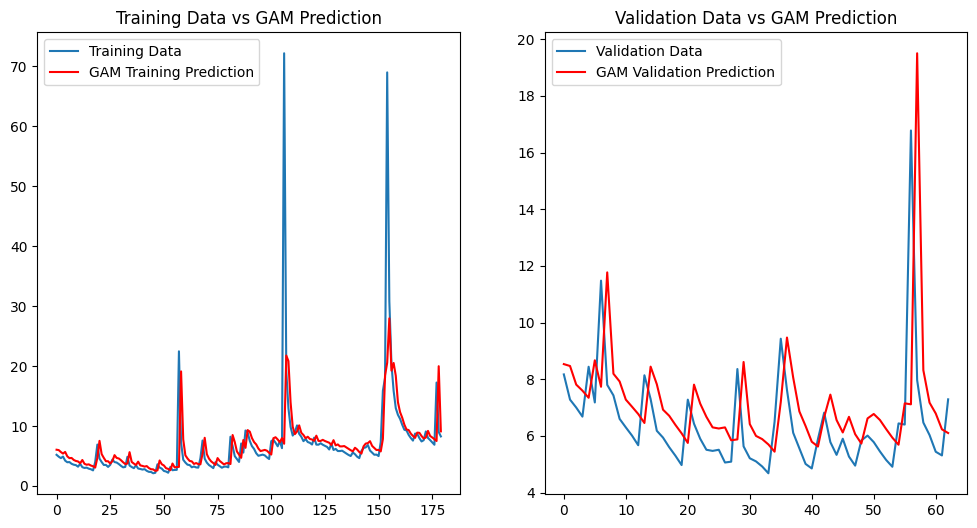

In [22]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train = X_ger[:180]
y_train = y_ger[:180]

X_valid = X_ger[180:]
y_valid = y_ger[180:]

# Define the model with a smoothing term for the first feature
gam = LinearGAM(s(8))

# Fit the model on the training set
gam.fit(X_train, y_train)

# Predict using the model on both training and validation sets
y_train_pred = gam.predict(X_train)
y_valid_pred = gam.predict(X_valid)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data and predictions
plt.subplot(1, 2, 1)
plt.plot(y_train, label='Training Data')
plt.plot(y_train_pred, color='red', label='GAM Training Prediction')
plt.title('Training Data vs GAM Prediction')
plt.legend()

# Plot validation data and predictions
plt.subplot(1, 2, 2)
plt.plot(y_valid.reset_index(drop=True), label='Validation Data')
plt.plot(y_valid_pred, color='red', label='GAM Validation Prediction')
plt.title('Validation Data vs GAM Prediction')
plt.legend()

plt.show()

=> ne marche pas car on a juste y_ger = f(X_ger) avec X_ger décalé de 1, il apprend juste un spline sur X_ger décalé de 1. Donc marche à l'entraînement mais pas à la validation.

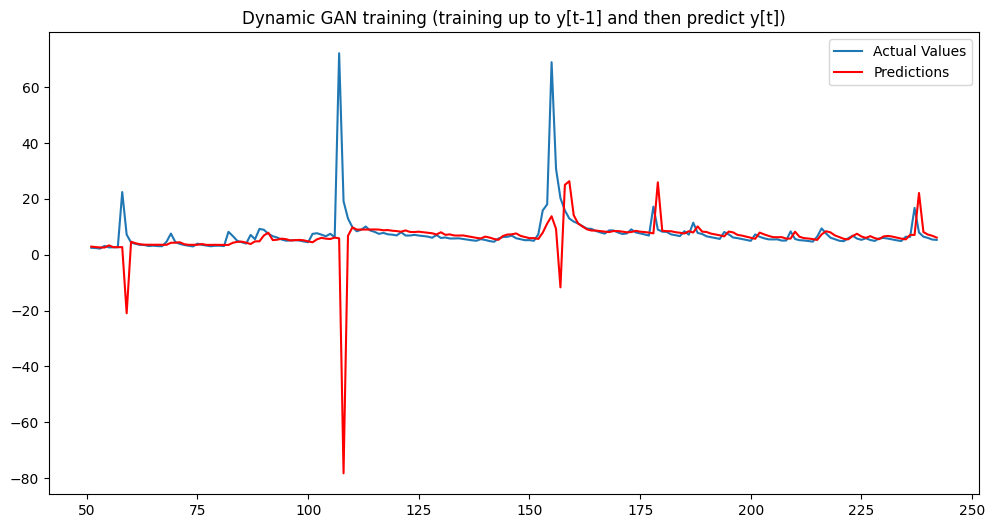

In [29]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

predictions = []
actuals = []

for t in range(50, len(X_ger) -1):
    # Define the training set
    X_train = X_ger.iloc[:t]
    y_train = y_ger[:t]
    
    # print(X_train["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"][:t])
    # print(X_train["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"][[t]])
    # print(y_train[t])
    # Define the model with a smoothing term for the first feature
    gam = LinearGAM(s(8, n_splines=30))
    
    # Fit the model on the training set
    gam.fit(X_train, y_train)
    
    # Predict y[t+1]
    y_pred = gam.predict(X_ger.iloc[[t]])
    # print(y_pred[0])
    # Store the prediction and the actual value
    predictions.append(y_pred[0])
    actuals.append(y_ger[t])

plt.figure(figsize=(12, 6))

# Plot actual values and predictions
plt.plot(range(51, len(X_ger)), actuals, label='Actual Values')
plt.plot(range(51, len(X_ger)), predictions, color='red', label='Predictions')
plt.title('Dynamic GAN training (training up to y[t-1] and then predict y[t])')
plt.legend()

plt.show()

Ici, idée : apprendre un nouveau spline à chaque étape : marche moyen car une seule valeur pour apprendre, chaque pas temporel est maintenant vu comme une feature. Toujours ce problème de décalage

## Dynamic GAM

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 70% (7 of 10) |#################        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 70% (7 of 10) |#################        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 70% (7 of 10) |#################        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 70% (7 of 10) |#################        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                        

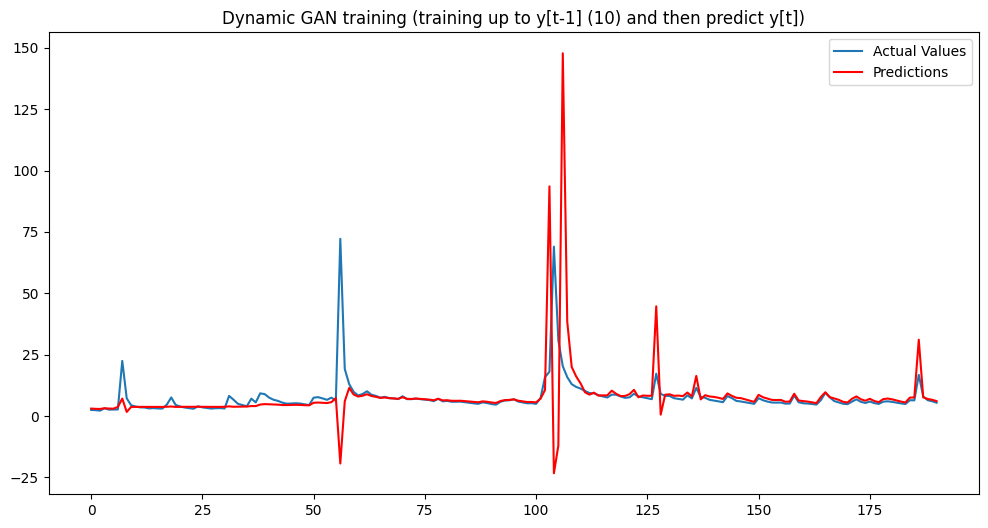

In [100]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


np.random.seed(0)


actuals = []
predictions = []
k0 = 2

# Create a new DataFrame to store the shifted columns
X_shifted = pd.DataFrame(X_ger["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"])

# Loop to create shifted columns from 1 to 10
for shift in range(k0):
    X_shifted[f'shift_{shift}'] = X_ger['GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]'].shift(shift)

# Drop rows with NaN values created by shifting
X_shifted = X_shifted.dropna()
y_shifted = y_ger[k0:]


for t in range(50, len(X_shifted) -1):
    # Define the training set
    X_train = X_shifted.iloc[:t]
    y_train = y_shifted[:t]

    gam = LinearGAM(s(0) + s(1, n_splines=15) + s(2, n_splines = 10))
    lam = np.logspace(-3, 3, 10)

    # Fit the model on the training set
    gam.fit(X_train, y_train)
    gam.gridsearch(X_train, y_train, lam=lam)

    y_pred = gam.predict(X_shifted.iloc[[t]])

    predictions.append(y_pred[0])
    actuals.append(y_shifted[t])
    

plt.figure(figsize=(12, 6))

# Plot actual values and predictions
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, color='red', label='Predictions')
plt.title('Dynamic GAN training (training up to y[t-1] (10) and then predict y[t])')
plt.legend()

plt.show()